# Economic Growth

# 8.4.1 モデルについて

あるcomposite goodを生産し、消費する経済を考える.

・毎年、財は数量$s$で始まり、うち$x$が投資に、残り$(s-x)$が消費に充てられる.

・また、social benefitとして$u(s-x)$が生じる.

・毎年はじめに利用できる財の量はcontinuous-valued Markov processによって以下のようにコントロールされる

$$s_{t+1} = \gamma x_t + \epsilon_{t+1}h(x_t)$$

・$\gamma$はcapital survival rate(1-減価償却率)、$h$は総生産関数、$\epsilon$は正の生産ショック(平均が1)を表す.

ここでは、現在、そして将来にわたるsocial benefitの総和を最大化するような消費と投資のpolicyについて考える.

・このモデルはinfinite horizonである.$ｘ$は投資量を決定するアクションである.

$$s\in[0,\infty), x\in[0,s]$$

・状態遷移関数(state transition function)は次のように表される.

$$g(s,x,\epsilon)=\gamma x + \epsilon h(x)$$

・reward functionは次のように表される.

$$f(s,x)=u(s-x)$$

ストック$s$が与えられたとき、現在と将来のsocial benefitの和はBellman equationを満たす.

$$V(s)=\max_{0\leq x \leq s}\{u(s-x) + \delta E_\epsilon V(\gamma x +\epsilon h(x))\}$$

$u'(0)=\infty$と$h(0)=0$を仮定すると、最適条件ではconstraintsは拘束力を持たない

In [1]:
using QuantEcon
using BasisMatrices
using Optim

In [2]:
using Interpolations

In [3]:
using Plots

In [4]:
struct GrowthModel
    alpha::Float64
    beta::Float64
    gamma::Float64
    sigma::Float64
    delta::Float64 #discount factor
    s_vec::Vector{Float64}
end

In [5]:
n = 500 #ここを大きくするとdpsimulのspathが7.5に近づく
smin = 0
smax = 10
fspace = Basis(ChebParams(n, smin, smax))

snodes = nodes(fspace);

In [6]:
GM = GrowthModel(0.2, 0.5, 0.9,0.1,0.9, snodes[1])

GrowthModel(0.2, 0.5, 0.9, 0.1, 0.9, [2.4674e-5, 0.000222064, 0.000616838, 0.00120898, 0.00199846, 0.00298526, 0.00416933, 0.00555063, 0.00712909, 0.00890467  …  9.9911, 9.99287, 9.99445, 9.99583, 9.99701, 9.998, 9.99879, 9.99938, 9.99978, 9.99998])

In [7]:
function update_bellman!(GM::GrowthModel,V::Vector)
    a,b,g,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta
    V_func = LinInterp(GM.s_vec, V)
    V_new = similar(V)
    x_opt = similar(V)
    
    nshocks = 3
    e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
    
    for (s_idx,s) in enumerate(GM.s_vec)
        objective(x) = -(((s - x)^(1 - a)/(1 - a)) + d * dot(V_func.(g*x + e*(x^b)), w))
        opt = optimize(objective, 1e-10, s)
        V_new[s_idx] = - opt.minimum
        x_opt[s_idx] = opt.minimizer
    end
    return V_new,x_opt
end

update_bellman! (generic function with 1 method)

In [8]:
V = Vector{Float64}(length(GM.s_vec))
for i in 1:length(GM.s_vec)
V[i] = 5
end

In [9]:
n = 500
V_computed = similar(V)
x_opt = similar(V)
resid1 = Vector{Float64}(n)

for i in 1:n
    V_func =  LinInterp(snodes[1], V)
    V_computed, x_opt = update_bellman!(GM,V)
    for j in 1:length(V_computed)
        resid1[j] =  V_computed[j] - V[j]
    end
    copy!(V, V_computed)
end


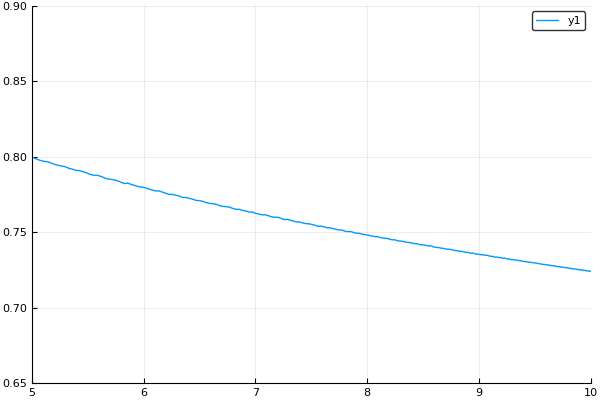

In [10]:
x_per = similar(V)
for i in 1:length(x_per)
    x_per[i] = x_opt[i] / GM.s_vec[i]
end

plot(GM.s_vec, x_per,xlim=(5,10),ylim=(0.65,0.9))


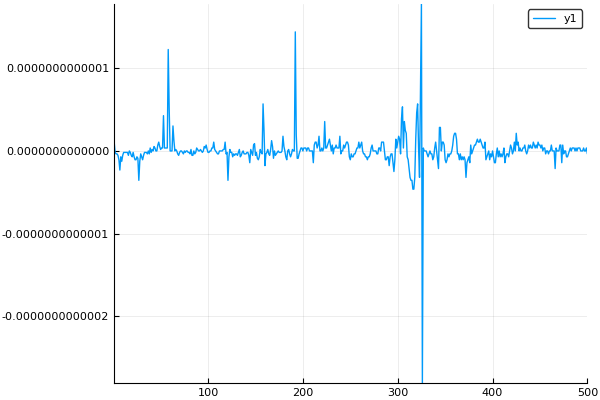

In [11]:
plot(resid1)

LQapprox部分の実装

方法１

In [12]:
GM::GrowthModel
a,b,gamma,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta

estar = 1 #教科書訂正
xstar = ((1 - d*gamma)/(d*b))^(1/(b - 1))
sstar = gamma*xstar + xstar^b
cstar = sstar - xstar

gx = gamma+b*((xstar)^(b-1))
f = (cstar^(-a))/(1-a)
fs = cstar^(-a)
fss = -a*(cstar^(-a-1))

A = [0 gamma*xstar+(xstar^b)-sstar;
     0                 1]
B = [gx;
     0]
C = zeros(2,1)

R = [-1/2*fss -1/2*fs;
     -1/2*fs  -f]
Q = -1/2*fss
N = [1/2*fss 1/2*fs]

lq = LQ(Q,R,A,B,C,N; bet=d)

P, F, d =  stationary_values(lq)

([0.0 -2.84217e-14; 0.0 -51.2464], [-1.0 9.0374], 0.0)

方法２:transition functionをreward functionに入れ込む

In [13]:
GM::GrowthModel
a,b,gamma,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta

estar = 1 #教科書訂正
xstar = ((1 - d*gamma)/(d*b))^(1/(b - 1))
sstar = gamma*xstar + xstar^b
cstar = sstar - xstar

m1 = gamma*sstar + sstar^b -xstar
m2 = gamma+b*(sstar)^(b-1)

u = (m1^(1-a))/(1-a)
us = (m1^(-a))*m2
ux = -(m1^(-a))
uss = m1^(-a)*(b-1)*sstar^(b-2) + m2^2*(-a)*m1^(-a-1)
uxx = -a*(m1^(-a-1))
usx = a*(m1^(-a-1))*m2

A = zeros(2,2)
B = [1;
     0]
C = zeros(2,1)

R = [-1/2*uss -1/2*us;
     -1/2*us -u]
Q = -1/2*uxx

N = [-1/2*usx -1/2*ux]

lq = LQ(Q,R,A,B,C,N; bet=d)

P, F, d =  stationary_values(lq)

([0.0209329 -0.200212; -0.200212 -7.38542], [-0.560922 9.80736], 0.0)

In [14]:
s0 = [5.0;1.0]
s_path,x_path = compute_sequence(lq,s0)

([5.0 -7.00275 … -1.72873e-24 -9.69682e-25; 1.0 0.0 … 0.0 0.0], [-7.00275 -3.928 … -1.72873e-24 -9.69682e-25], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [15]:
s_path

2×101 Array{Float64,2}:
 5.0  -7.00275  -3.928  -2.2033  -1.23588  …  -1.72873e-24  -9.69682e-25
 1.0   0.0       0.0     0.0      0.0          0.0           0.0        

In [16]:
-x_path

1×100 Array{Float64,2}:
 7.00275  3.928  2.2033  1.23588  0.693233  …  1.72873e-24  9.69682e-25

In [17]:
slq = reshape(x_path,100,1);


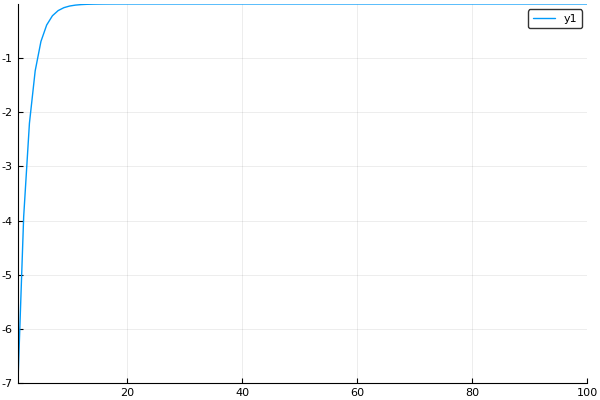

In [18]:
plot(slq)

LQ Approximation with QuantEcon.jlより、`approx_lq`を以下のように設定する。

In [19]:
function approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount)
    n = 2  # Dim of state variable (1, s)
    k = 1  # Dim of control variable x
    sx_star = [s_star, x_star]
    
    # (1, s)' R (1, s) + 2 x N (1, s) + x Q x
    Q = Array{Float64}(k, k)
    R = Array{Float64}(n, n)
    N = Array{Float64}(k, n)
    R[1, 1] = -(f_star - Df_star' * sx_star + (sx_star' * DDf_star * sx_star) / 2)
    R[2, 2], N[1, 2], N[1, 2], Q[1, 1] = -DDf_star / 2
    R[2, 1], N[1, 1] = -(Df_star - DDf_star * sx_star) / 2
    R[1, 2] = R[2, 1]
    
    # A (1, s) + B x + C w
    A = Array{Float64}(n, n)
    B = Array{Float64}(n, k)
    C = zeros(n, 1)
    A[1, 1], A[1, 2], B[1, 1] = 1, 0, 0
    A[2, 1] = g_star - Dg_star' * sx_star
    A[2, 2], B[2, 1] = Dg_star
    
    lq = LQ(Q, R, A, B, C, N, bet=discount)
    return lq
end

approx_lq (generic function with 1 method)

xstar,sstarについてreward function,state transition functionを展開し、以下のように設定する。

In [20]:

GM::GrowthModel
a,b,gamma,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta

x_star = ((1 - d*gamma)/(d*b))^(1/(b - 1))
s_star = gamma*x_star + x_star^b


f_star = (s_star-x_star)^(1-a)/(1-a)
Df_star = [(s_star-x_star)^(-a), -(s_star-x_star)^(-a)]
DDf_star = [(-a)*(s_star-x_star)^(-a-1) a*(s_star-x_star)^(-a-1);
            a*(s_star-x_star)^(-a-1) a*(s_star-x_star)^(-a-1)]
g_star = gamma*x_star + x_star^b
Dg_star = [0, gamma+b*x_star^(b-1)]
discount = d;

In [21]:
s_star

7.416897506925212

In [22]:
f_star

2.0070983979777237

In [23]:
q = approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount)

QuantEcon.LQ([-0.0491487], [-3.33384 -0.533012; -0.533012 0.0491487], [1.0 0.0; 1.18421 0.0], [0.0; 1.11111], [0.0; 0.0], [1.0844 -0.0491487], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [24]:
P, F, d = stationary_values(lq)

([0.0209329 -0.200212; -0.200212 -7.38542], [-0.560922 9.80736], 0.0)

`compute_sequence`を用いてs_pathを導出する。

In [25]:
ts_length = 300
s0 = [5.0,1.0]
s_path,x_path = compute_sequence(lq,s0, ts_length)

([5.0 -7.00275 … -1.04293e-74 -5.85e-75; 1.0 0.0 … 0.0 0.0], [-7.00275 -3.928 … -1.04293e-74 -5.85e-75], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [26]:
s_path

2×301 Array{Float64,2}:
 5.0  -7.00275  -3.928  -2.2033  -1.23588  …  -1.04293e-74  -5.85e-75
 1.0   0.0       0.0     0.0      0.0          0.0           0.0     


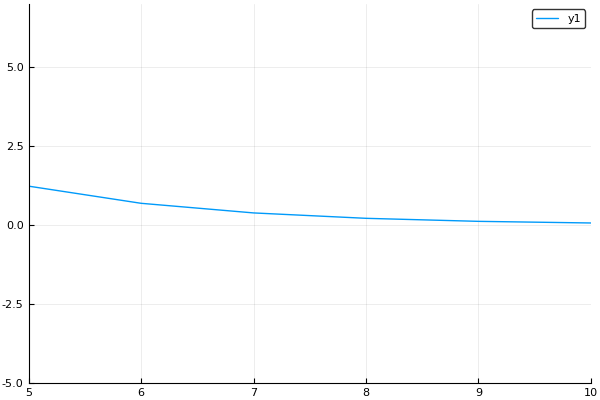

In [27]:
plot(-s_path[1, :],xlim=(5,10))

今までよりはまともな図が出たように見える。
次にvalueを導出する。

In [28]:
Vlq(s) = [1, s]' * P * [1, s] + d

Vlq (generic function with 1 method)

In [29]:
Vlq(s_star)

-409.223659328857

s_starに対してのVlqが妙に大きい。先に`stationary_values`で求めたPに問題がある？


とりあえずこのまま教科書通りに投資量(x)/資本(s)のグラフを描画する。

In [30]:
X(s) = (- F * [1, s])[1]

X (generic function with 1 method)

In [31]:
X(7)

-68.09059387873502


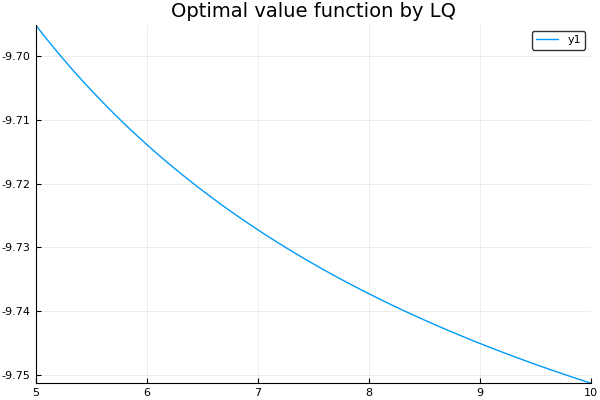

In [32]:
ss = linspace(5, 10, 100)
plot(ss, X.(ss)./ss, title="Optimal value function by LQ")

投資量が多すぎる…。

次に、value function iterationを試してみる。

In [33]:
function riccati_rhs(P, lq)
    Q, R, A, B, N, bet = lq.Q, lq.R, lq.A, lq.B, lq.N, lq.bet
    A0, B0 = sqrt(bet) * A, sqrt(bet) * B
    out = R - (B0' * P * A0 + N)' * inv(Q + B0' * P * B0) *
        (B0' * P * A0 + N) + A0' * P * A0
    return out
end

riccati_rhs(P) = riccati_rhs(P, lq)

riccati_rhs (generic function with 2 methods)

In [34]:
function compute_F(P, lq)
    s1 = lq.Q + lq.bet * (lq.B' * P * lq.B)
    s2 = lq.bet * (lq.B' * P * lq.A) + lq.N
    F = s1 \ s2
    return F
end

compute_F (generic function with 1 method)

In [35]:
max_iter = 500
err_tol = 1e-15
P_init = [1.0 2;
          3 4]
P_vi = compute_fixed_point(riccati_rhs, P_init, max_iter=max_iter,
                           verbose=2, print_skip=50, err_tol=err_tol)

Converged in 30 steps


2×2 Array{Float64,2}:
  0.0209329  -0.200212
 -0.200212   -7.38542 

Pは先ほどと変わらず、P_initを変更しても変化なし。

ステップ数が妙に少ないのが原因？

dpsimulの実装

In [36]:
function GM_dpsimul(GM::GrowthModel,sinit,nyrs,sres,xres)
    a,b,g,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta

    nrep = length(sinit) #npath
    nshocks = 3
    e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
    ssim = zeros(nrep,nyrs+1)
    xsim = zeros(nrep,nyrs+1)
    
    rv = DiscreteRV(w)
    trans(x) = (g*x) + e[rand(rv)]*x^b #state transition function
        
    for t in 1:nyrs+1
        li = LinInterp(sres, xres)
        xx = Vector{Float64}(length(sinit))
        for i in 1:length(sinit)
            xx[i]=li(sinit[i])
        end
        ssim[:,t] = sinit
        xsim[:,t]= xx
        for i in 1:length(sinit) -1
            sinit[i+1] = trans(xx[i])
        end
    end
        
    return ssim,xsim
end

GM_dpsimul (generic function with 1 method)

In [37]:
nshocks = 3
e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
d = DiscreteRV(w);

e[rand(d, 5)]

5-element Array{Float64,1}:
 0.995012
 0.836771
 0.995012
 0.995012
 1.18318 

In [38]:
nyrs = 20
npath = 2000
sinit = 5*ones(npath,1) 

spath,xpath = GM_dpsimul(GM,sinit,nyrs,snodes[1],x_opt);

In [39]:
spath_x = vec(mean(spath,1))

21-element Array{Float64,1}:
 5.0    
 5.60056
 6.06433
 6.41118
 6.68572
 6.88189
 7.02402
 7.13094
 7.21008
 7.26494
 7.29836
 7.32986
 7.34923
 7.36797
 7.38488
 7.39418
 7.39084
 7.39763
 7.40521
 7.39678
 7.40227


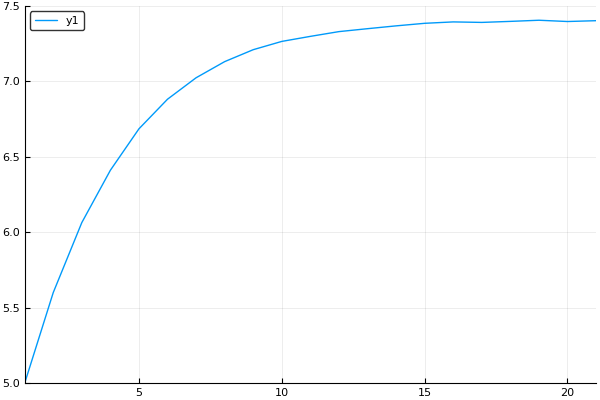

In [40]:
plot(spath_x,ylim=(5.0,7.5))

dpststの実装

In [41]:
function dpstst(GM::GrowthModel,nsmooth,nnodes,scoord,x)
    a,b,g,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta
    smin = scoord[1]
    smax = scoord[end]
    swid = (smax - smin)/nnodes
    smid = linspace(smin+swid/2,smax-swid/2,nnodes) 
    nshocks = 3
    e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
    
    m = length(w)
    ss = gridmake(smid)
    xx = similar(ss)
    q = ones(length(ss))
    for t in 1:nsmooth
        li = LinInterp(scoord,x)
        for k in 1:length(ss)
            xx[k] = li(ss[k])
        end
        ss,xx,ee = gridmake([ss,xx],e)
        for r in 1:length(ss)
            ss[r] = g*xx[r] + xx[r]^b
        end
        for l in 1:length(ss)
            @show q
            @show w
            @show q[l]
            q[l] = q[l]*w' #?
        end
    end
    nobs = m^nsmooth
    ss = reshape(ss,nnodes,nobs)
    q = reshape(q,nnodes,nobs)
        
    p = zeros(nnodes,nnodes)
    for j in 1:nobs
        i = ceil((ss[:,j]-smin)/swid)
        i = min(max(i,1),nnodes)
        ind = (1:nnodes)'+(i-1)*nnodes
        p[ind] = p[ind] + q[i,j]
    end
    mc = MarkovChain(p)
    p = stationary_distributions(mc)
    
    return smid,p,xx
end

dpstst (generic function with 1 method)

In [89]:
nnodes = 20
nyrs = 20
s_dist = Array{Float64}(nyrs,nyrs)

for i in 1:nnodes
    npath = 1000
    sinit = 5*ones(npath,1) 
    spath,xpath = GM_dpsimul(GM,sinit,nyrs,snodes[1],x_opt)
    spath_x = vec(mean(spath,1))
    s_dist[i,:] = spath_x[2:end]
end

In [90]:
s_dist

20×20 Array{Float64,2}:
 5.60311  6.07503  6.42076  6.67578  …  7.38859  7.39462  7.3882   7.38588
 5.60137  6.06484  6.42085  6.67157     7.39801  7.40721  7.40508  7.40774
 5.59688  6.05381  6.41467  6.68439     7.40806  7.41257  7.41233  7.41755
 5.59361  6.06244  6.41557  6.69063     7.41645  7.41388  7.41799  7.40924
 5.60606  6.07285  6.42105  6.67986     7.40517  7.4032   7.39605  7.40684
 5.58495  6.06125  6.43257  6.69002  …  7.39819  7.40137  7.40942  7.41074
 5.60618  6.06818  6.41945  6.68927     7.38604  7.37658  7.39057  7.39653
 5.59328  6.05679  6.41382  6.68543     7.40564  7.41341  7.41797  7.42025
 5.60143  6.07631  6.41816  6.68172     7.38092  7.39267  7.39966  7.3985 
 5.59773  6.05613  6.4201   6.67617     7.38744  7.40159  7.39328  7.38301
 5.59755  6.0536   6.42085  6.67542  …  7.39506  7.39098  7.40313  7.39972
 5.60462  6.06199  6.4097   6.68445     7.3798   7.3792   7.38793  7.38491
 5.60654  6.06675  6.43538  6.69122     7.41463  7.41131  7.40655  7.41628
 

In [91]:
re_s_dist=reshape(s_dist,(length(s_dist)),1)

400×1 Array{Float64,2}:
 5.60311
 5.60137
 5.59688
 5.59361
 5.60606
 5.58495
 5.60618
 5.59328
 5.60143
 5.59773
 5.59755
 5.60462
 5.60654
 ⋮      
 7.3985 
 7.38301
 7.39972
 7.38491
 7.41628
 7.40886
 7.41275
 7.40212
 7.39938
 7.38578
 7.39232
 7.42058


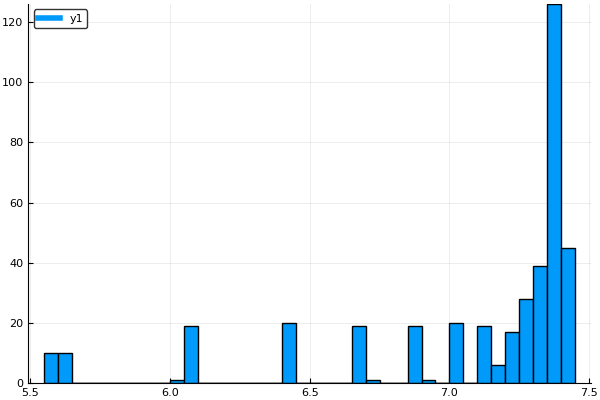

In [92]:
histogram(re_s_dist, nbins=80)